<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import copy
import nachopy
import importlib
import pickle
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 500
%config InlineBackend.figure_formats = ['svg'] # Will change this in future if needed
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns

from joblib import dump, load # Using joblib as more efficient for sklearn models according to documentation

importlib.reload(nachopy)

<module 'nachopy' from 'C:\\Users\\Nacho\\Capstone-project-Brainstation\\nachopy.py'>

Let's load the data. We will have a training_v1 which has the features plus the class (as well as an eventtype grouped class). From this we are extracting X_trn_v1, the array of the training features, and y_trn_v1, the binarised events. X_tst_v1 is the first version of the test feature array and events_tst_v1 is the first version of the classes, from which we will extract y_tst_v1 (binarised classes for test set). The version number will increase as we apply transformation to our datasets. For example, after merging classes we will create events and y variables with v2, but the training and X objects will remain as v1 as they are not edited at that stage. Model names will be followed by "_version of X_version of y"

In [2]:
training_v1 = pd.read_pickle('G:/My Drive/Capstone-Data/pickles/training_df_v1.pkl')
X_tst_v1 = pd.read_pickle('G:/My Drive/Capstone-Data/pickles/X_test_v1.pkl')
events_tst_v1 = pd.read_pickle('G:/My Drive/Capstone-Data/pickles/y_test_v1.pkl')

Let's extract the feature and try a simple logistic regression model. We can binarise our y datasets using sklearn's LabelEncoder.

In [3]:
from sklearn.preprocessing import LabelEncoder

X_trn_v1 = training_v1.drop(columns = ['event','eventtype'])

le_v1 = LabelEncoder()
le_v1.fit(training_v1.event)
y_trn_v1 = le_v1.transform(training_v1.event)
y_tst_v1 = le_v1.transform(events_tst_v1)

In [4]:
# Importing functions and classes
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models
from sklearn.decomposition import PCA

cv = 5 

# Defining pipeline
# In our pipeline, the data will be normalised before a logistic regression is fitted 
estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())] # And logistic regression only (as specified in grid as well)

pipe = Pipeline(estimators)
# Defining parameter grid

# n_range = [5,10,15]
C_range = np.logspace(1,10,num = 4) # Setting range of C values

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

# Creating grid using 10 folds (this is the standard and we have enough data so that the training set will not be too small)
grid_logreg = GridSearchCV(pipe, param_grid, cv = cv)
# Fitting grid (or models)
logreg_v1_1 = grid_logreg.fit(X_trn_v1, y_trn_v1)
display(logreg_v1_1.best_estimator_)
print(logreg_v1_1.best_score_)

dump(logreg_v1_1,'models/logreg_v1_1.joblib')

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10000.0))])

0.4104466506786024


['models/logreg_v1_1.joblib']

In [4]:
logreg_v1_1 = load('models/logreg_v1_1.joblib')

CV score of 0.41, which is low but expected. Let's see the performance of the model on the test set

Best model's CV score: 0.4104466506786024
Best model's test score 0.18403019204670099
Baseline model (score of a model that always predicts majoritary class) 0.23


<Figure size 2000x2000 with 0 Axes>

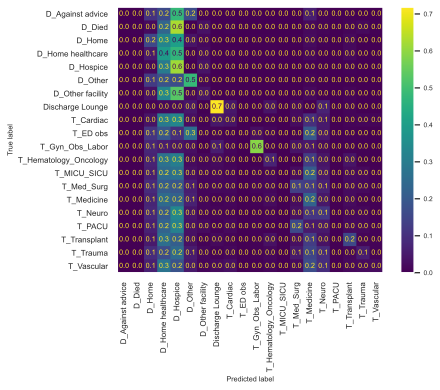

<Figure size 2000x2000 with 0 Axes>

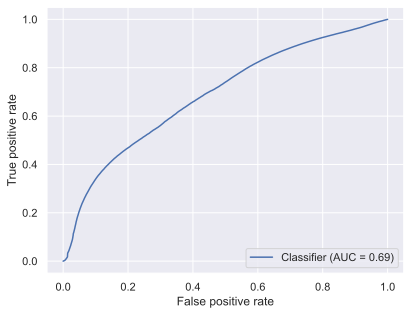

In [8]:
%config InlineBackend.figure_formats = ['svg'] # Will change this in future if needed
importlib.reload(nachopy)
nachopy.roc_n_confusion(logreg_v1_1,
                        X_tst_v1,
                        y_tst_v1,
                        lbl_enc = le_v1,
                        incl_val=True)

As we see above, the model does a bad job at predicting all classes and gets particularly confused at the different discharge types. This is a good thing as we can merge these classes (our goal is predicting transfer to departments or discharge, not discharge types. Let's do this and reassess. As seen in the EDA, Discharge Lounge is an actual care unit so we will leave it separate. 

In [5]:
training_v1_2 = training_v1.copy()
training_v1_2['event'] =  training_v1.event.str.replace('D_Home.*|D_Other facility|D_Hospice','Discharge')
events_tst_v2 = events_tst_v1.str.replace('D_Home.*|D_Other facility|D_Hospice','Discharge')

le_v2 = LabelEncoder()
le_v2.fit(training_v1_2['event'])
y_trn_v2 = le_v2.transform(training_v1_2['event'])
y_tst_v2 = le_v2.transform(events_tst_v2)

In [7]:
# Importing functions and classes
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models
from sklearn.decomposition import PCA

cv = 5 

# Defining paipeline
# In our pipeline, the data will be normalised before a logistic regression is fitted 
estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())] # And logistic regression only (as specified in grid as well)

pipe = Pipeline(estimators)
# Defining parameter grid

# n_range = [5,10,15]
C_range = np.logspace(1,10,num = 4) 

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

logreg_v1_2 = grid.fit(X_trn_v1, y_trn_v2)
display(logreg_v1_2.best_estimator_)
print(logreg_v1_2.best_score_)

dump(logreg_v1_2,'models/logreg_v1_2.joblib')

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10000000.0))])

0.5688659193320894


['models/logreg_v1_2.joblib']

Best model's CV score: 0.5688659193320894
Best model's test score 0.48027291825466173
Baseline model (score of a model that always predicts majoritary class) 0.43


<Figure size 2000x2000 with 0 Axes>

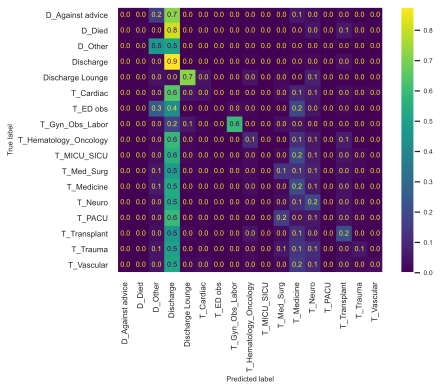

<Figure size 2000x2000 with 0 Axes>

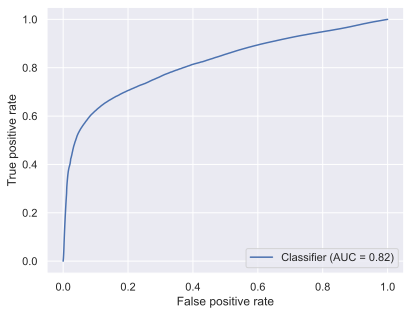

In [10]:
logreg_v1_2 = load('models/logreg_v1_2.joblib')

importlib.reload(nachopy)
nachopy.roc_n_confusion(logreg_v1_2,
                        X_tst_v1,
                        y_tst_v2,
                        lbl_enc = le_v2,
                        incl_val = True)

That is better for the discharges, but the accuracy for the transfers is similar. We also see that the precision for class discharge is very low, because of the class imbalance. Let's re-merge the discharge classes.

In [6]:
training_v1_3 = training_v1_2.copy()
training_v1_3.loc[training_v1_3.event.str.contains('D_',regex = False),'event'] = 'Discharge'

events_tst_v3 = events_tst_v2.copy()
events_tst_v3[events_tst_v3.str.contains('D_',regex = False)] = 'Discharge'

le_v3 = LabelEncoder().fit(training_v1_3.event)
y_trn_v3 = le_v3.transform(training_v1_3.event)
y_tst_v3 = le_v3.transform(events_tst_v3)

Let's look first at the class imbalance again

In [57]:
class_labels_df = pd.DataFrame.from_dict({'Labels':np.unique(y_trn_v3),\
                        'Classes':events_trn_v3.unique(),'Size':events_trn_v3.value_counts()}).set_index('Classes',drop = True)

class_labels_df['Size'] = class_labels_df.Size.apply(lambda x: 45000 if x < 45000 else x)
oversampling = class_labels_df.set_index('Labels').Size.to_dict()

Let's fix that class imbalance with some smoting followed by undersampling. We will add _res to the resampled data

In [50]:
# Importing functions and classes
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models

cv = 5 

estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())]

pipe = Pipeline(estimators)
# Defining parameter grid

# n_range = [5,10,15]
C_range = np.logspace(1,10,num = 4)

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

logreg_v1_3 = grid.fit(X_trn_v1, y_trn_v3)
display(logreg_v1_3.best_estimator_)
print(logreg_v1_3.best_score_)

dump(logreg_v1_3,'models/logreg_v1_3.joblib');

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10.0))])

0.6119219587259641


NameError: name 'logreg_v1_3_res' is not defined

In [7]:
logreg_v1_3 = load('models/logreg_v1_3.joblib')

Best model's CV score: 0.6119219587259641
Best model's test score 0.6119888897918987
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

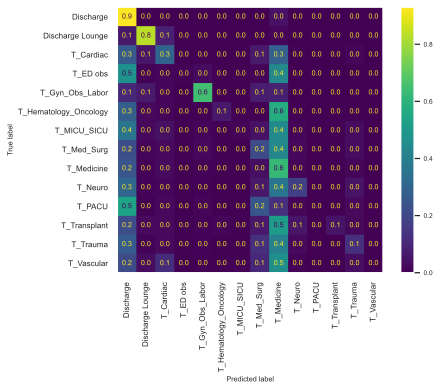

<Figure size 2000x2000 with 0 Axes>

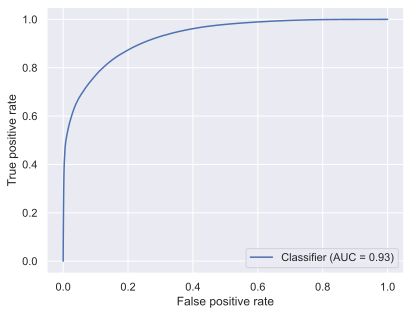

In [57]:
nachopy.roc_n_confusion(logreg_v1_3,
                        X_trn_v1,
                        y_trn_v3,
                        lbl_enc = le_v3
                       )

Some metrics improved, but others not so much. There is still a large class imbalance, we could try to smote the rest to the classes up to the level of the discharge classes. Before that, we can have a look at the feature importance for each class. 

In [8]:
logreg_v1_3_coefs = pd.DataFrame(index = logreg_v1_3.best_estimator_.feature_names_in_,
                                      columns = le_v3.inverse_transform(np.arange(14)),
                                      data = logreg_v1_3.best_estimator_.named_steps.model.coef_.T
                                     )

<Figure size 3200x2400 with 0 Axes>

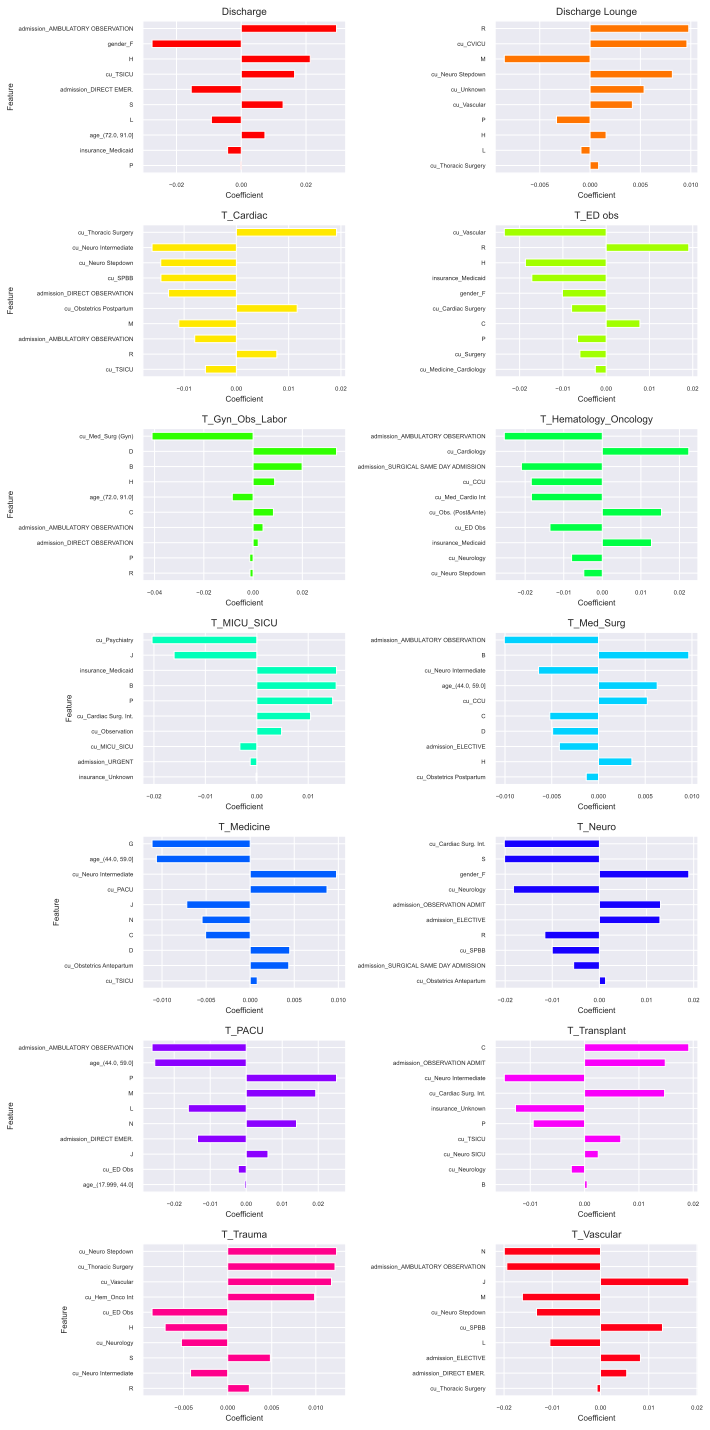

In [55]:
fig,axs = plt.subplots(7,2,figsize = (10,20))

cmap = plt.cm.get_cmap('hsv', 14)
for i,event in enumerate(logreg_v1_3_coefs):
    
    plt.subplot(7, 2, i+1) 
    
    # Plotting new df to ensure all possible admission types shown
    logreg_v1_3_coefs[event].sort_values(key=abs).head(10).plot.barh(color = cmap(i))
    # Adding to new df (overwritten with every loop) so sorting of admission types is kept
    # Plotting
    
    plt.title(event,fontsize = 10)
    plt.ylabel('')
    plt.xticks(fontsize = 6,rotation = 0)
    plt.yticks(fontsize = 6)
    plt.xlabel('Coefficient',fontsize = 8)
    if i%2 == 0:
        plt.ylabel('Feature',fontsize = 8)
    

plt.tight_layout(pad = 1)
plt.show()

Care units and prescriptions are quite prominent features. We can add more features of the kind easily by increasing granularity for prescriptions (classifying by level 2-4 of ATC instead of level 1) and/or adding features for the past transfers of the patients. We have these last features ready to add and it would would 70 features instead of the 400 features that we would add if we increased granularity for prescriptions. Let's do that.

In [45]:
# We save the current progress to add features and do an EDA on the feature engineering notebook
training_v1_3.to_pickle('../Capstone-Data/pickles/training_v1_3.pkl')
X_tst_v1.to_pickle('../Capstone-Data/pickles/X_tst_v1.pkl')

In [8]:
# After adding the features we can import the dfs again
training_v2_3= pd.read_pickle('G:/My Drive/Capstone-Data/pickles/training_v2_3.pkl')
X_tst_v2= pd.read_pickle('G:/My Drive/Capstone-Data/pickles/X_tst_v2.pkl')
X_trn_v2 = training_v2_3.drop(columns = ['event','eventtype'])

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

estimators_v1 = [('scaler', StandardScaler()), # Scaling for PCA
              ('model',PCA())]  # Initialising with n_components equal to number of features to evaluate features

estimators_v2 = [('scaler', StandardScaler()), # Scaling for PCA
              ('model',PCA())]  # Initialising with n_components equal to number of features to evaluate features

pca_pipe_v1 = Pipeline(estimators_v1)
pca_pipe_v2 = Pipeline(estimators_v2)

pca_pipe_v1.fit(X_trn_v1)
pca_pipe_v2.fit(X_trn_v2)

X_trn_v1_pca = pca_pipe_v1.transform(X_trn_v1)
X_trn_v2_pca = pca_pipe_v2.transform(X_trn_v2)

We have lots of features, let's do a PCA to get an idea of which might be the most important/the most redundant

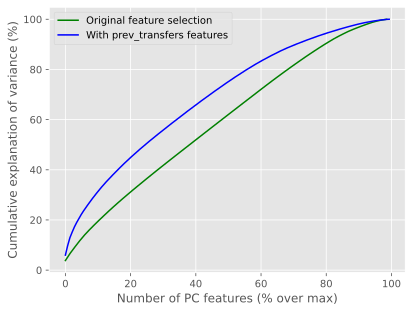

In [15]:
%config InlineBackend.figure_formats = ['svg'] # Will change this in future if needed

plt.figure()

plt.plot(np.arange(X_trn_v1.shape[1])/X_trn_v1.shape[1]*100,
         pca_pipe_v1.named_steps.model.explained_variance_ratio_.cumsum()*100,
         color = 'green',
         label = 'Original feature selection'
        )

plt.plot(np.arange(X_trn_v2.shape[1])/X_trn_v2.shape[1]*100,
         pca_pipe_v2.named_steps.model.explained_variance_ratio_.cumsum()*100,
         color = 'blue',
         label = 'With prev_transfers features'
        )

plt.legend()

plt.ylabel('Cumulative explanation of variance (%)')
plt.xlabel('Number of PC features (% over max)')
plt.show()

The original set of features seems to be quite independent. This was expected, and observed in the EDA, and it is due to having many categorical features. Upon addition of the prev_transfers features colinearity increased and we see that more variance of the model can be explained with fewer features. Let's look at the most important features (the ones that have the largest eigenvalues in the PC components).

In [16]:
pc_eigens = pd.DataFrame(index = np.arange(X_trn_v2.shape[1]),
             columns = X_trn_v2.columns,
             data = pca_pipe_v2.named_steps.model.components_
            )

nachopy.display_sbs([pc_eigens.idxmax(axis = 1).value_counts().head(10).rename('# of PCs where top feature'),
                     pc_eigens.idxmin(axis = 1).value_counts().head(10).rename('# of PCs where bottom feature')],
                    titles = ['Top features','Bottom features'])

Top features 
 
 
   
 # of PCs where top feature 
 
 
 
 
 dur_Med/Surg 
 3 
 
 
 dur_Hematology/Oncology Intermediate 
 3 
 
 
 cu_Surgery 
 3 
 
 
 cu_Obstetrics Antepartum 
 3 
 
 
 cu_Med_Surg (Gyn) 
 3 
 
 
 cu_Medicine_Cardiology 
 3 
 
 
 freq_Medical/Surgical (Gynecology) 
 2 
 
 
 freq_Trauma SICU (TSICU) 
 2 
 
 
 cu_MICU_SICU 
 2 
 
 
 admission_AMBULATORY OBSERVATION 
 2 
 
 
 

 
 Bottom features 
 
 
   
 # of PCs where bottom feature 
 
 
 
 
 insurance_Medicaid 
 4 
 
 
 freq_Vascular 
 4 
 
 
 insurance_Other 
 3 
 
 
 dur_Trauma SICU (TSICU) 
 3 
 
 
 J 
 3 
 
 
 cu_Med_Cardio Int 
 3 
 
 
 cu_Thoracic Surgery 
 3 
 
 
 freq_Cardiology Surgery Intermediate 
 3 
 
 
 cu_Med_Surg_GYN 
 3 
 
 
 freq_Hematology/Oncology 
 3

The new variables have added quite a lot of variance to the model as these have the most weight in several of the PCs. Current care unit feature also features prominently. However, current and past care units are also among the features with the highest number of lowest eigenvalues in PCA. This may not be the best way to assess feature importance in this case as we have lots of categorical variables (as ohe, frequency-encoded featuers), so the variance in the data is going to be quite high without that meaning better prediction power. Let's fit a random forest to find the top feature importance.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc_200 = RandomForestClassifier(n_estimators=200)

rfc_200.fit(X_trn_v2,y_trn_v3)

RandomForestClassifier(n_estimators=200)

Best model's test score 0.98835276663623
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

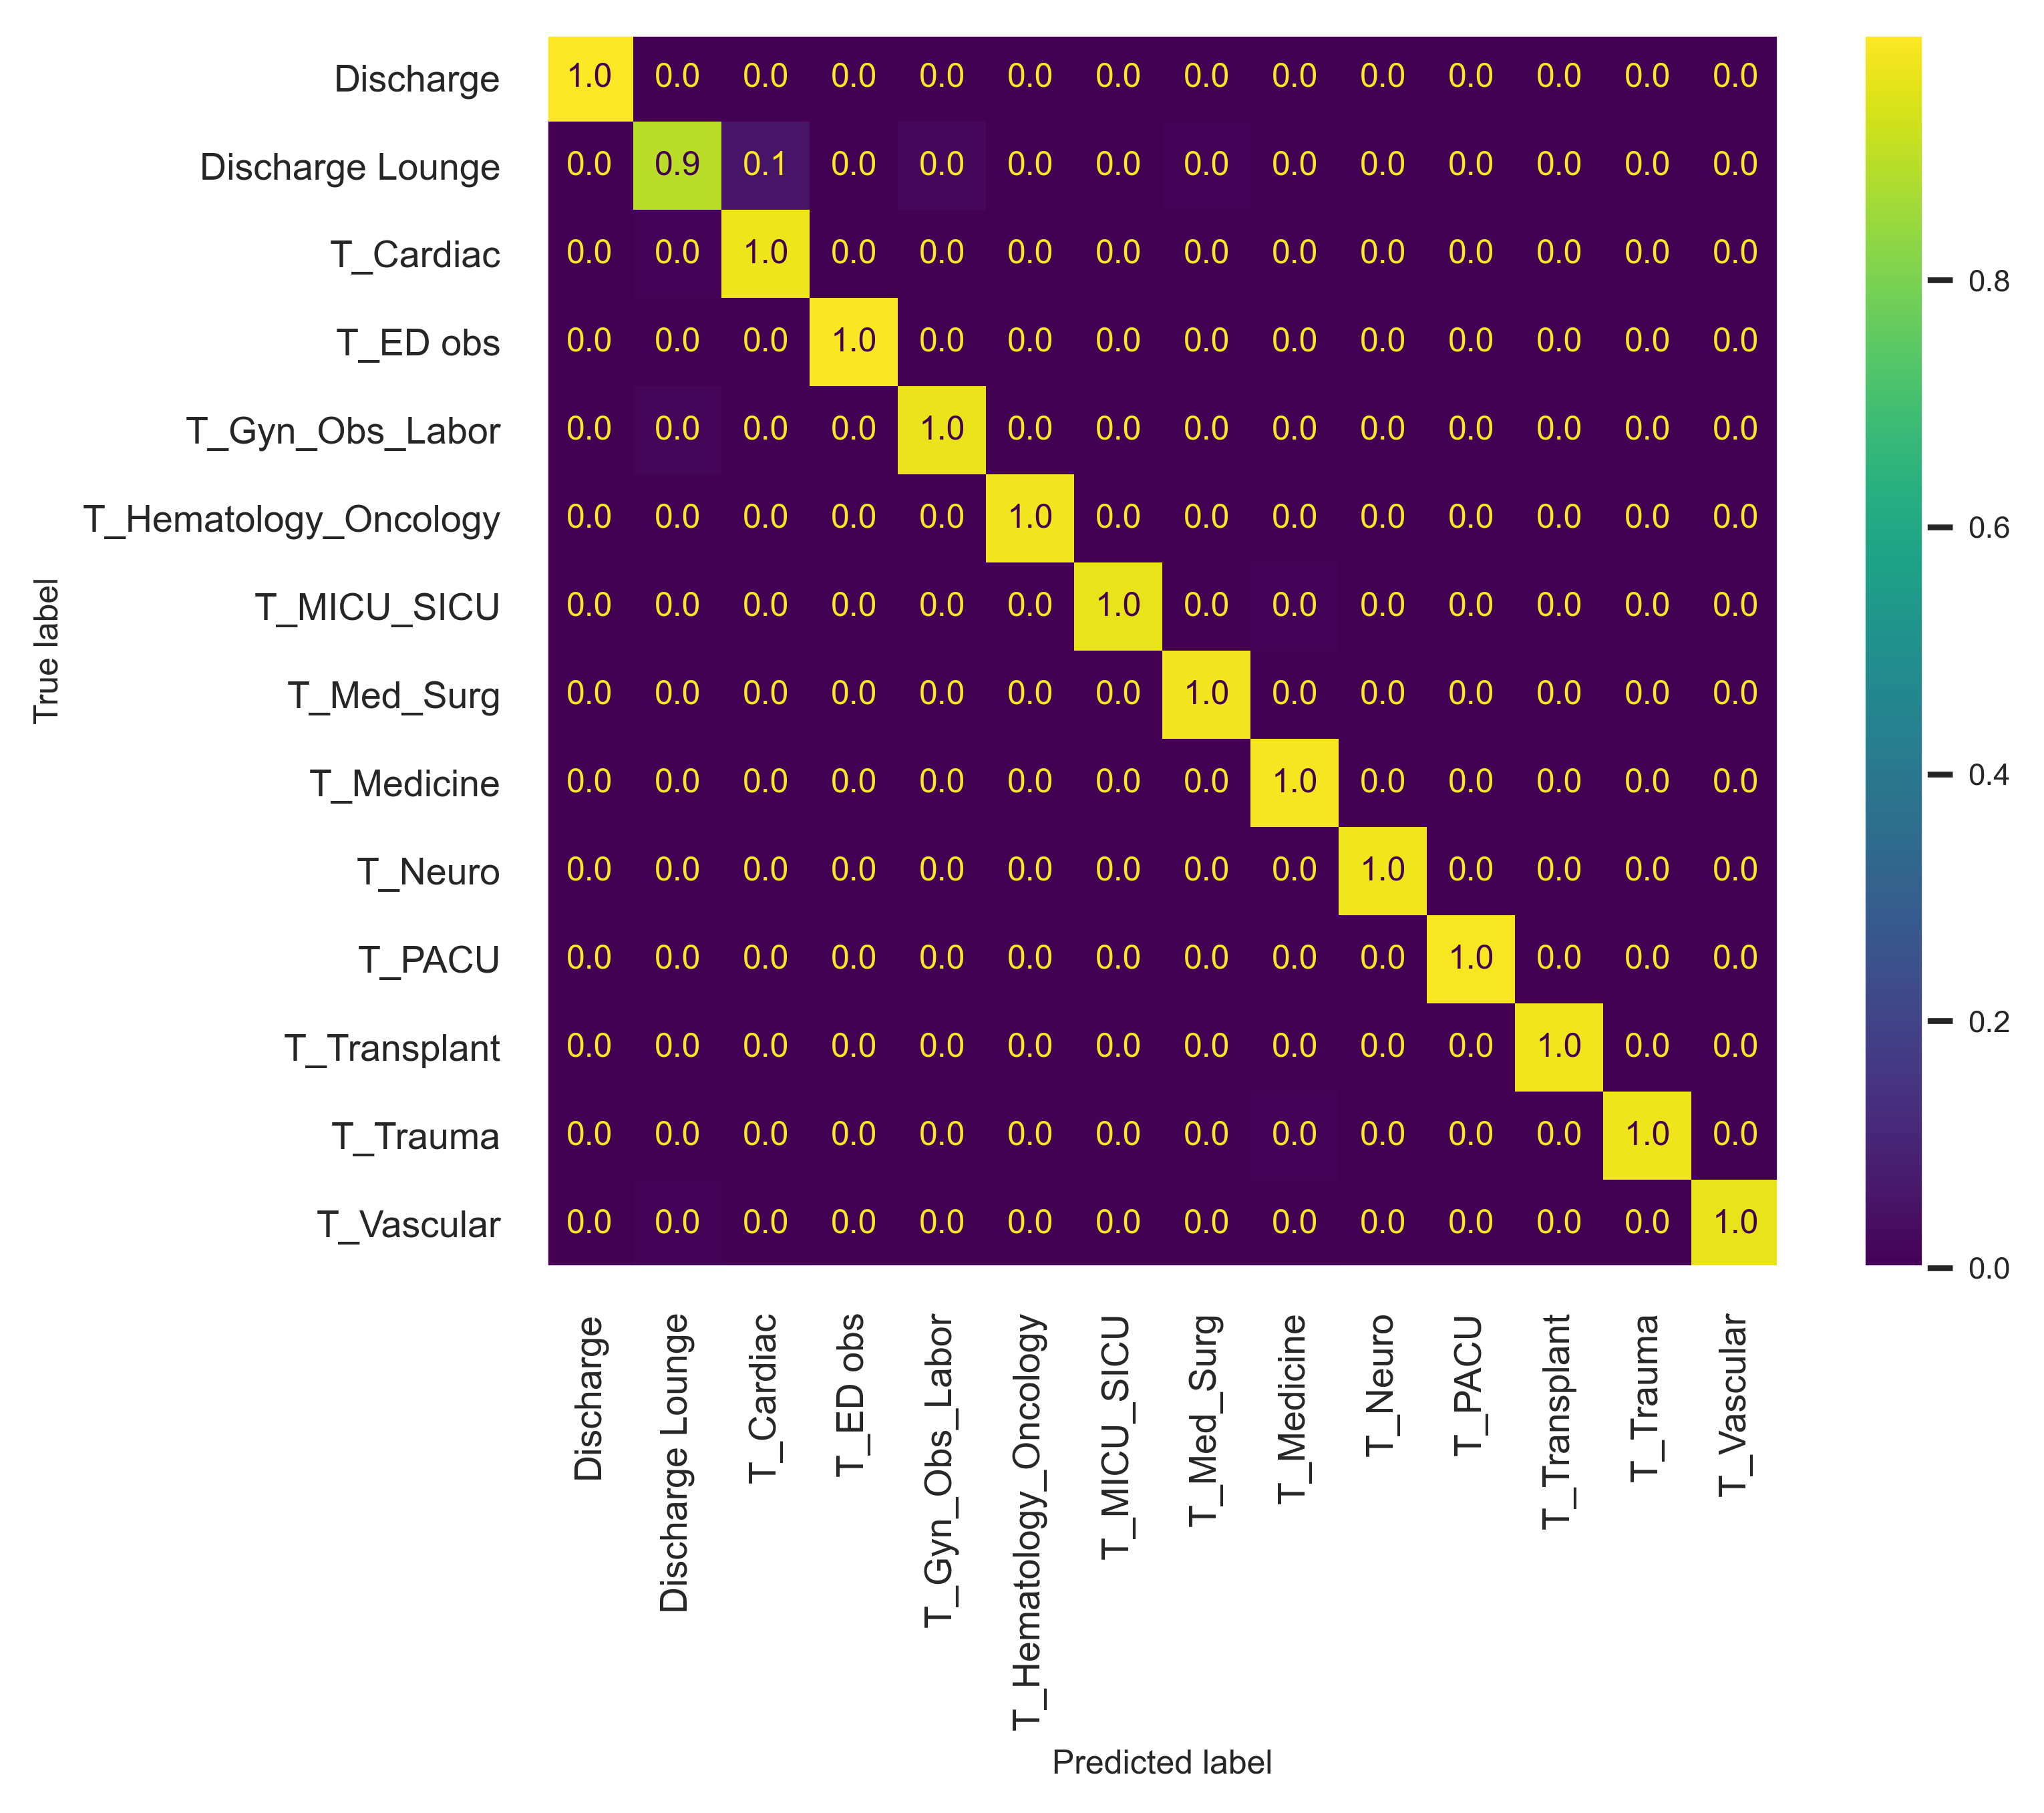

<Figure size 2000x2000 with 0 Axes>

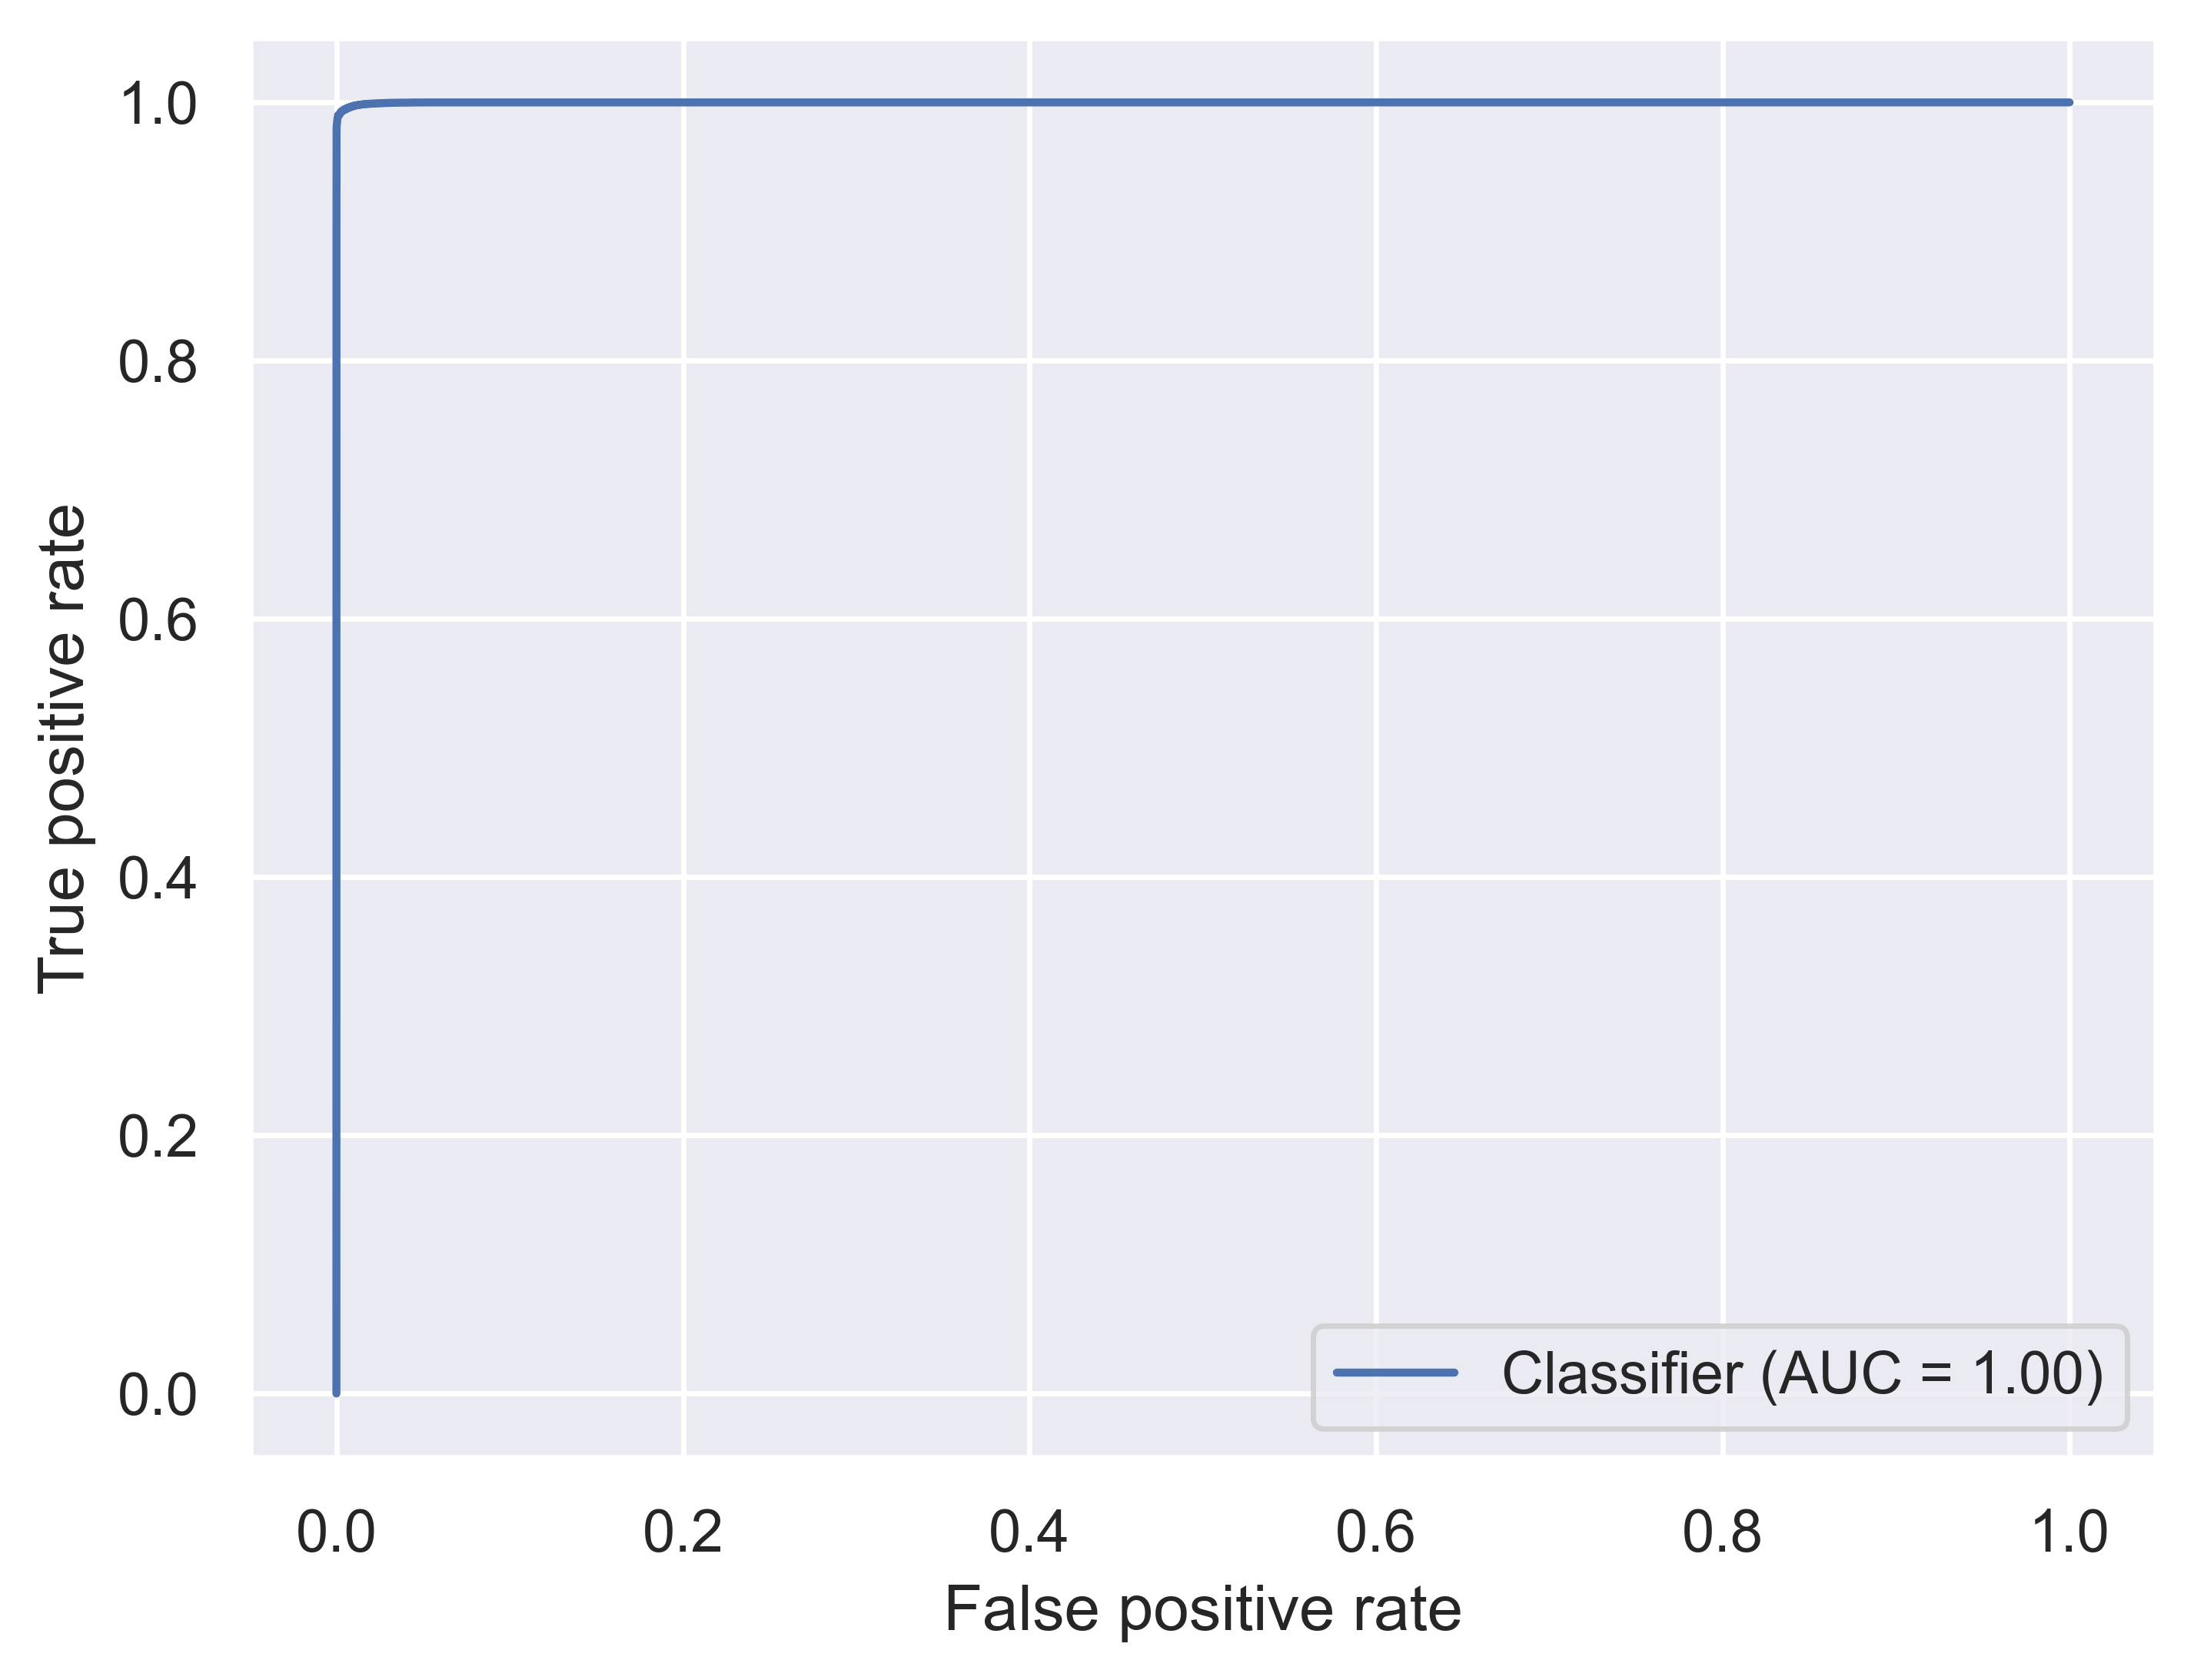

In [12]:
nachopy.roc_n_confusion(rfc_200,
                        X_trn_v2,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc_100 = RandomForestClassifier(n_estimators=100)

rfc_100.fit(X_trn_v2,y_trn_v3)

RandomForestClassifier()

Best model's test score 0.9883240827943162
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

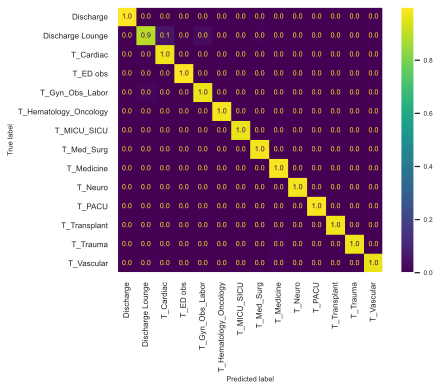

<Figure size 2000x2000 with 0 Axes>

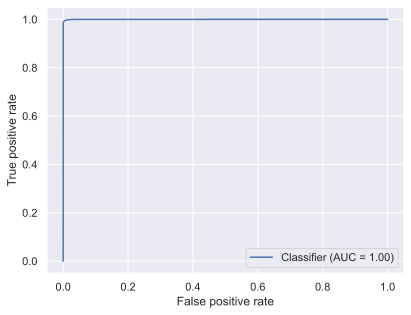

In [16]:
%config InlineBackend.figure_formats = ['svg'] # Will change this in future if needed
nachopy.roc_n_confusion(rfc_100,
                        X_trn_v2,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=40, max_features=0.2))])

Best model's CV score: 0.6600646005289772
Best model's test score 0.9469667633949558
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

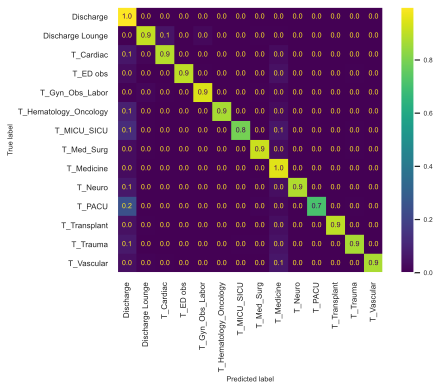

<Figure size 2000x2000 with 0 Axes>

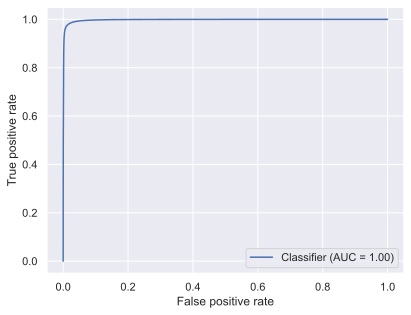

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

cv = 5 

estimators = [('scaler', StandardScaler()),
              ('model',RandomForestClassifier())] 

pipe = Pipeline(estimators)

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[RandomForestClassifier()], # Model
        'model__criterion':['gini','entropy'], # Regularisation parameter
        'model__max_depth':[5, 40, 80],
        'model__max_features':['sqrt','log2', 0.2]
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

rfccv_v2_3_sc = grid.fit(X_trn_v2, y_trn_v3)
display(rfccv_v2_3_sc.best_estimator_)

nachopy.roc_n_confusion(rfccv_v2_3_sc,
                        X_trn_v2,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )
dump(rfccv_v2_3_sc,'G:/My Drive/Capstone-data/models/rfccv_v2_3.joblib');

In [11]:
rfccv_v2_3_sc = load('G:/My Drive/Capstone-data/models/rfccv_v2_3_sc.joblib')

In [9]:
rfccv_v2_3 = load('G:/My Drive/Capstone-data/models/rfccv_v2_3.joblib')

Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=0.1,
                                        min_samples_split=0.1))])

Best model's CV score: 0.49644559392789267
Best model's test score 0.49644559392285004
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

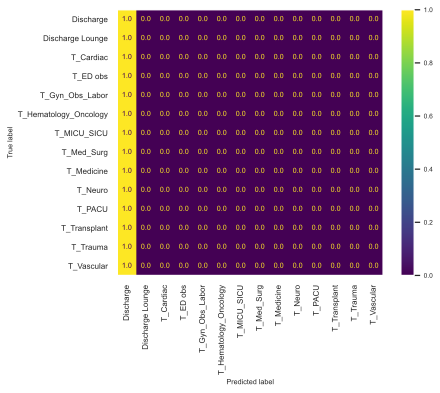

<Figure size 2000x2000 with 0 Axes>

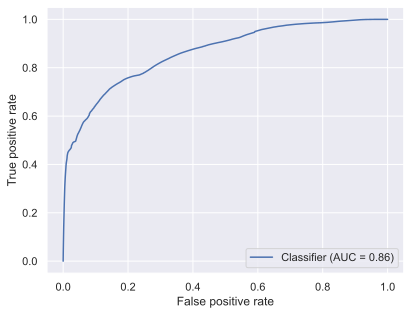

FileNotFoundError: [Errno 2] No such file or directory: 'G:/My Drive/Capstone-data/models/rfccv_v2_3.joblib'

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

cv = 5 

pipe = Pipeline([('model',RandomForestClassifier())])

param_grid = [
    {
        'model':[RandomForestClassifier()], # Model
        'model__criterion':['gini'], # We can stick to gini which is significantly faster
        'model__max_depth':[5, 40, 80],
        'model__min_samples_split':[0.1, 0.3, 0.5],
        'model__max_features':['sqrt','log2', 0.2],
        'model__min_samples_leaf':[0.1, 0.3, 0.5]
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

rfccv_v2_3 = grid.fit(X_trn_v2, y_trn_v3)
display(rfccv_v2_3.best_estimator_)

nachopy.roc_n_confusion(rfccv_v2_3,
                        X_trn_v2,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )
dump(rfccv_v2_3,r'G:/My Drive/Capstone-data/models/rfccv_v2_3.joblib');

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

cv = 5 

pipe = Pipeline([('model',RandomForestClassifier())])

param_grid = [
    {
        'model':[RandomForestClassifier()],
        'model__criterion':['gini'],
        'model__max_depth':[40, 80, 120],
        'model__min_samples_split':[2, 10, 50, 100],
        'model__max_features':['sqrt','log2', 0.2],
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

rfccv_v2_3 = grid.fit(X_trn_v2, y_trn_v3)
display(rfccv_v2_3.best_estimator_)

nachopy.roc_n_confusion(rfccv_v2_3,
                        X_trn_v2,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )
# Overwriting model, but not the dumped file
dump(rfccv_v2_3,r'G:/My Drive/Capstone-data/models/rfccv_v2_3_2.joblib');

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

cv = 5 

pipe = Pipeline([('model',RandomForestClassifier())])

param_grid = [
    {
        'model':[RandomForestClassifier()],
        'model__n_estimators':[25,50,75,100],
        'model__max_depth':[40],
        'model__min_samples_split':[2, 100],
        'model__max_features':[0.2],
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv,verbose = 1)

rfccv_v2_3_v2 = grid.fit(X_trn_v2, y_trn_v3)
display(rfccv_v2_3_v2.best_estimator_)

nachopy.roc_n_confusion(rfccv_v2_3_v2,
                        X_trn_v2,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )
# Overwriting model, but not the dumped file
dump(rfccv_v2_3_v2,r'G:/My Drive/Capstone-data/models/rfccv_v2_3_v2.joblib');

In [ ]:
feature_importances = pd.Series(rfccv_v2_3.best_estimator_.named_steps.model.feature_importances_,\
          index = rfccv_v2_3.feature_names_in_)

with pd.option_context("display.max_rows",150):
    display(feature_importances.sort_values(ascending = False))

print(feature_importances.describe())

X_trn_v2 = X_trn_v2[feature_importances[feature_importances>feature_importances.median()].index]

Let's evaluate this feature selection by fitting another model 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    # Transformer to select top features (columns must be sorted by order of importance)
    # Features_no is a float to indicate the top features
    def __init__(self, features_no = 1):
        self.features_no = features_no
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        # The last column is selected 
        last_col = round(self.features_no * len(X.columns))
        X_ = X[X.columns[:last_col].copy()
        
        X_ = X[features[round(feature_number*len(features))]]
        return X_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

cv = 5 

pipe = Pipeline([('model',RandomForestClassifier())])

param_grid = [
    {
        'model':[RandomForestClassifier()], # Model
        'model__criterion':['gini'], # We can stick to gini which is significantly faster
        'model__max_depth':[5, 40, 80],
        'model__min_samples_split':[0.1, 0.3, 0.5],
        'model__max_features':['sqrt','log2', 0.2],
        'model__min_samples_leaf':[0.1, 0.3, 0.5]
    }
]

grid = GridSearchCV(pipe, param_grid, cv = cv)

rfccv_v3_3 = grid.fit(X_trn_v3, y_trn_v3)
display(rfccv_v3_3.best_estimator_)

nachopy.roc_n_confusion(rfccv_v3_3,
                        X_trn_v3,
                        y_trn_v3,
                        lbl_enc=le_v3
                       )
dump(rfccv_v3_3,'G:/My Drive/Capstone-data/models/rfccv_3_3.joblib');

In [12]:
rfccv_v2_3.best_params_

{'model': RandomForestClassifier(max_depth=5, min_samples_leaf=0.1, min_samples_split=0.1),
 'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 0.1,
 'model__min_samples_split': 0.1}

Let's remove half the features with the least importance and refit the model again.

In [90]:
pc_eigens.idxmin(axis = 1).value_counts().head(20)

insurance_Medicaid                                   4
freq_Vascular                                        4
insurance_Other                                      3
dur_Trauma SICU (TSICU)                              3
J                                                    3
cu_Med_Cardio Int                                    3
cu_Thoracic Surgery                                  3
freq_Cardiology Surgery Intermediate                 3
cu_Med_Surg_GYN                                      3
freq_Hematology/Oncology                             3
freq_Cardiac Vascular Intensive Care Unit (CVICU)    3
cu_MICU                                              2
cu_Neuro Intermediate                                2
cu_Med_Surg                                          2
cu_CVICU                                             2
dur_Transplant                                       2
D                                                    2
admission_DIRECT OBSERVATION                         2
admission_

In [24]:
rfccv_v2_3.

0

In [ ]:
from imblearn.over_sampling import SMOTE

resampling = dict(zip(np.unique(y_trn_v3,return_counts=True)[0],np.unique(y_trn_v3,return_counts=True)[1]))

for event in resampling:
    resampling[event] = 45000 if resampling[event] < 45000 else resampling[event]

sm = SMOTE(sampling_strategy=resampling,random_state = 42)

X_trn_v1_res, y_trn_v3_res = sm.fit_resample(X_trn_v1,y_trn_v3)

np.unique(y_trn_v3_res,return_counts=True)

In [ ]:
np.unique(y_trn_v3_res,return_counts=True)

Now some undersampling

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

resampling[0] = 70000

enn = EditedNearestNeighbours(sampling_strategy='majority')

X_trn_v1_res, y_trn_v3_res = enn.fit_resample(X_trn_v1_res, y_trn_v3_res)

np.unique(y_trn_v3_res, return_counts=True)

In [9]:
X_trn_v1_res.to_pickle('../Capstone-Data/pickles/X_trn_v1_res.pkl')
y_trn_v3_res.dump('../Capstone-Data/pickles/y_trn_v3_res.npy')

NameError: name 'X_trn_v1_res' is not defined

Best model's CV score: 0.4690318418084926
Best model's test score 0.4943873282641432
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

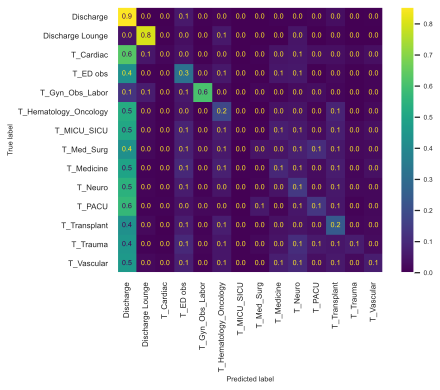

<Figure size 2000x2000 with 0 Axes>

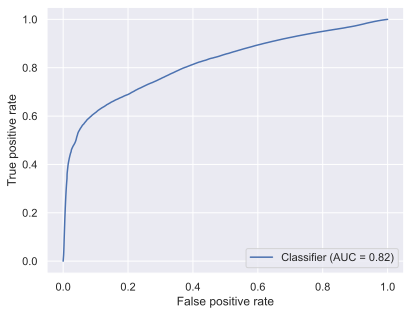

In [80]:
nachopy.roc_n_confusion(logreg_v1_3_res,X_tst_v1,y_tst_v3,lbl_enc=le_v3,incl_val = True)

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_trn_v2_sc = StandardScaler().fit_transform(X_trn_v2)

pca = PCA()
pca.fit(X_trn_v2_sc)

# X_trn_v1_res_sc_PCA = PCA(n_components=20).fit(X_trn_v1_res_sc)

PCA()

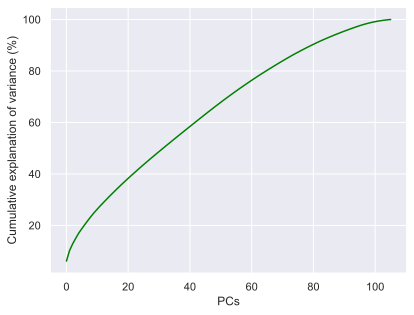

In [22]:
plt.plot(pca.explained_variance_ratio_.cumsum()*100,color = 'green')
plt.ylabel('Cumulative explanation of variance (%)')
plt.xlabel('PCs')
plt.show()

In [42]:
len(X_tst_v1)

268945

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc_v2_3 = RandomForestClassifier(random_state = 42)

rfc_v2_3.fit(X_trn_v2,y_trn_v3)

RandomForestClassifier(random_state=42)

Best model's test score 0.6217144769376638
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

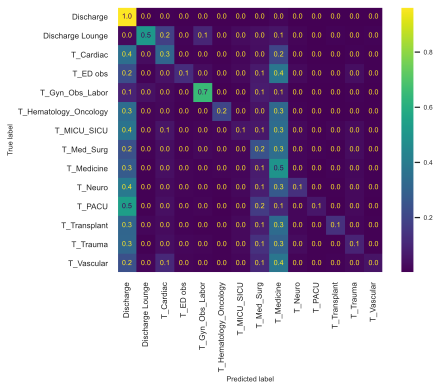

<Figure size 2000x2000 with 0 Axes>

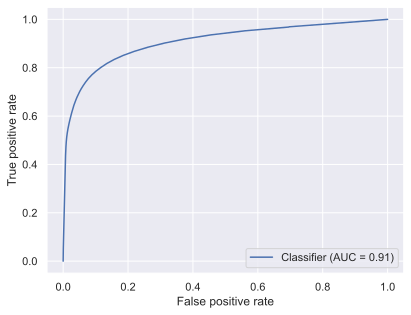

In [35]:
nachopy.roc_n_confusion(rfc_v2_3,X_tst_v2,y_tst_v3,lbl_enc = le_v3,incl_val=True)

In [11]:
feature_imp_rfc_v2_v3 = pd.Series(rfc_v2_v3.feature_importances_,index = rfc_v2_v3.feature_names_in_)
feature_imp_rfc_v2_v3.sort_values(ascending = False).head(20)

NameError: name 'rfc_v2_v3' is not defined

In [49]:
rfc_v1_3 = RandomForestClassifier(random_state=42)

rfc_v1_3.fit(X_trn_v1,y_trn_v3)

print(rfc_v1_3.score(X_trn_v1, y_trn_v3))

nachopy.roc_n_confusion(rfc_v1_3,X_tst_v1,y_tst_v3m,lbl_enc = le_v3,incl_val=True)

NameError: name 'y_tst_v3m' is not defined

In [ ]:
prev_transfers.columns[38]

In [12]:
prev_transfers = pd.read_pickle('G:/My Drive/Capstone-Data/pickles/prev_transfers.pkl')
X_trn_v3 = X_trn_v2.join(prev_transfers[prev_transfers.columns[39:]])

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_trn_v2_val, X_tst_v2_val, y_trn_v2_val, y_tst_v3_val = train_test_split(X_trn_v2, y_trn_v3,stratify=y_trn_v3, random_state = 42, test_size= 0.2)

X_trn_v3_val = X_trn_v2_val.join(prev_transfers[prev_transfers.columns[39:]])
X_tst_v3_val = X_tst_v2_val.join(prev_transfers[prev_transfers.columns[39:]])

rfc_v2_3 = RandomForestClassifier(random_state = 42)
rfc_v3_3 = RandomForestClassifier(random_state = 42)

rfc_v2_3.fit(X_trn_v2_val,y_trn_v3_val)
rfc_v3_3.fit(X_trn_v3_val,y_trn_v3_val)

RandomForestClassifier(random_state=42)

In [41]:
np.unique(y_trn_v3,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([311535,   4944,  44194,  12198,  24673,  13001,  25893,  42998,
         67942,  24794,   7186,  11482,  25204,  11487], dtype=int64))

In [40]:
np.unique(y_trn_v3_val,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([233651,   3708,  33145,   9149,  18505,   9751,  19420,  32248,
         50956,  18595,   5390,   8612,  18903,   8615], dtype=int64))

Training score using just frequency prev_transfers features 0.9895760738386224
Best model's test score 0.4845458080225391
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

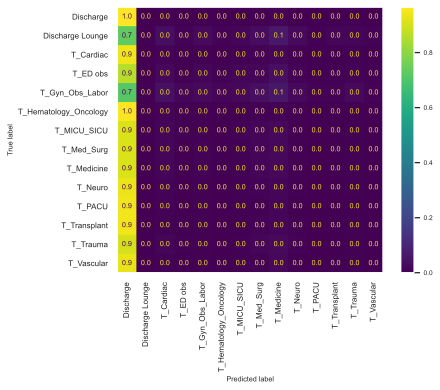

<Figure size 2000x2000 with 0 Axes>

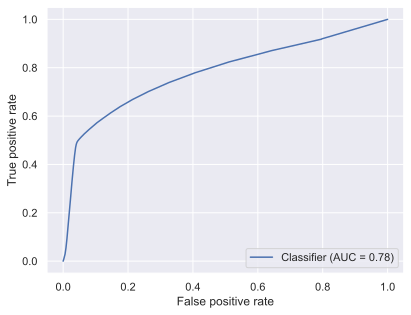

Training score using frequency and duratio prev_transfers featuers 0.9901752477435366
Best model's test score 0.48908422199983426
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

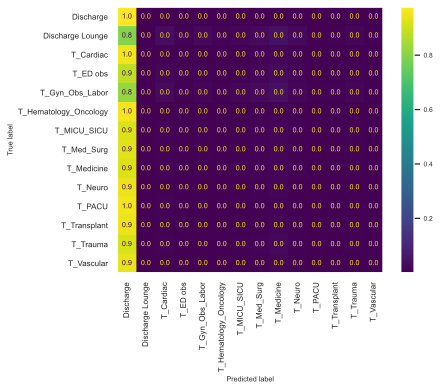

<Figure size 2000x2000 with 0 Axes>

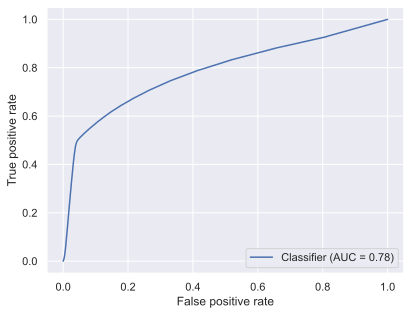

In [39]:
%config InlineBackend.figure_formats = ['svg'] # Will change this in future if needed

print('Training score using just frequency prev_transfers features',rfc_v2_3.score(X_trn_v2_val,y_trn_v3_val))
nachopy.roc_n_confusion(rfc_v2_3, X_tst_v2_val, y_tst_v3_val, lbl_enc=le_v3)

print('Training score using frequency and duratio prev_transfers featuers', rfc_v3_3.score(X_trn_v3_val,y_trn_v3_val))
nachopy.roc_n_confusion(rfc_v3_3,X_tst_v3_val, y_tst_v3_val, lbl_enc=le_v3)

0.9749271350738051
Best model's test score 0.5939727453568574
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

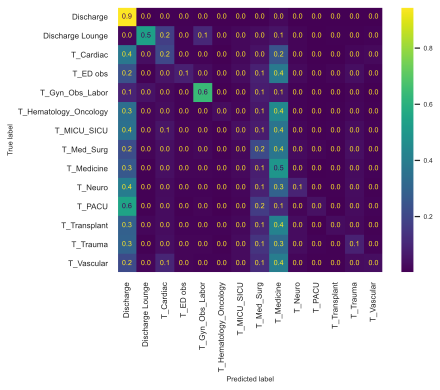

<Figure size 2000x2000 with 0 Axes>

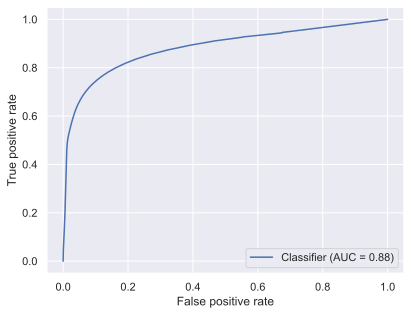

In [50]:
print(rfc_v1_3.score(X_trn_v1, y_trn_v3))
nachopy.roc_n_confusion(rfc_v1_3,X_tst_v1,y_tst_v3,lbl_enc = le_v3,incl_val=True)

In [52]:
rfc_v2_3.max_features

'sqrt'

Shifath:
Step 1
For small dataset
 - logistic regression SVM, decision tree and random forest, naive bayes
 - Group the classes before fitting the model
 - PCA to see if I can compress the model as it is right now
 - See if by going up on the number of features you are getting any gain
 - How many orders for now and that's it
 
 More manual feature selection/engineering tools 
  
 First random forest feature importances
 Take most important features and refit logreg
 select k best
 see if that improves model accuracy

 
 benchmark to discuss my model check literature. important for discussion
 
 FOr showcase:
 Be more specific, tell the story from the perspective of a single patient/group of patients
 Make the goal clear: Helping the delivery of the care system for (group of) patients
 What happen in a world where you don't build this/where this exists
 how can this be taken into account for the triage
 
 Bear in mind the inference, not just the prediction. understanding relationships. Which features correlate strongly?

Mark:
 - Fix class imbalance (downsampling home, upsampling least common)
 - Completing the EDA before and looking at relationship of features with classes (which imbalanced classes are more related to which features?)
 - Add easy features and fit (and make) grids, applying PCA to identify most important features
 - Increase granularity and repeat

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression(C = 10000000000))]

logreg_pipe = Pipeline(estimators)

logreg_pipe.fit(X_trn_v2,y_trn_v3)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10000000000))])

In [41]:
logreg_pipe.score(X_trn_v2,y_trn_v3)

0.6217111186538992

Best model's test score 0.4145643161241146
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

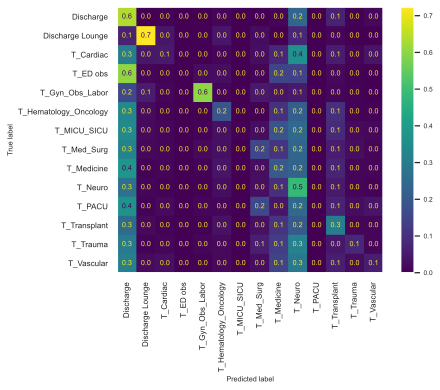

<Figure size 2000x2000 with 0 Axes>

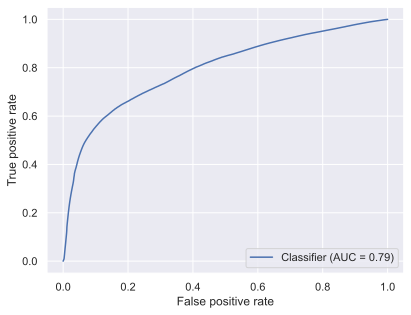

In [42]:
importlib.reload(nachopy)
nachopy.roc_n_confusion(logreg_pipe,X_tst_v2,y_tst_v3,lbl_enc=le_v3,incl_val = True)

In [72]:
estimators = [('scaler', MinMaxScaler()),
              ('model',LogisticRegression(C = 10000000000))]

logreg_pipe = Pipeline(estimators)

logreg_pipe.fit(X_trn_v1_res,y_trn_v3_res)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', LogisticRegression(C=10000000000))])

In [71]:
logreg_pipe.score(X_trn_v1,y_trn_v3)

0.5272775368866239

Best model's test score 0.11675621409581885
Baseline model (score of a model that always predicts majoritary class) 0.5


<Figure size 2000x2000 with 0 Axes>

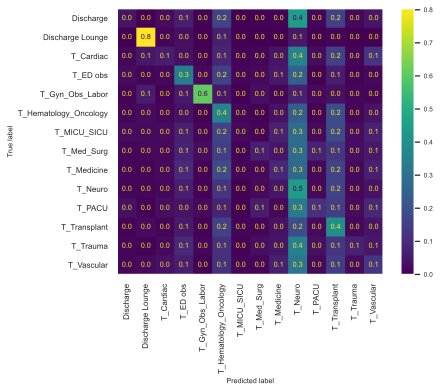

<Figure size 2000x2000 with 0 Axes>

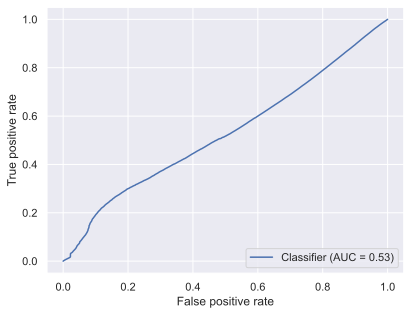

In [78]:
importlib.reload(nachopy)
nachopy.roc_n_confusion(logreg_pipe,X_tst_v1,y_tst_v3,lbl_enc=le_v3,incl_val = True)

In [91]:
class_labels = pd.DataFrame(np.unique(y_trn_v3_res,return_counts=True)).T
class_labels.index = le_v3.inverse_transform(np.arange(14))
class_labels

0       1
Discharge               0  173005
Discharge Lounge        1   45000
T_Cardiac               2   45000
T_ED obs                3   45000
T_Gyn_Obs_Labor         4   45000
T_Hematology_Oncology   5   45000
T_MICU_SICU             6   45000
T_Med_Surg              7   45000
T_Medicine              8   67942
T_Neuro                 9   45000
T_PACU                 10   45000
T_Transplant           11   45000
T_Trauma               12   45000
T_Vascular             13   45000